# Import packages

In [27]:
import sys
from brian2 import *
import sympy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy import signal
from scipy import optimize
from scipy import stats
from scipy.stats import gaussian_kde
import pickle
import yaml
import time
import h5py

import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
import warnings
warnings.filterwarnings(action='ignore', message='Mean of empty slice')

In [2]:
# import platform
# import sys
# os_name = platform.system()
# if os_name == 'Darwin':
#     sys.path.append('/Users/kperks/mnt/engram_share/home/kep2142/scripts/Python/Analysis/')
# if os_name == 'Linux':
#     sys.path.append('/mnt/engram/scripts/Python/Analysis/')
# from ClassDef_AmplitudeShift_Stable import AmpShift_Stable
# from Plotting import figsave, create_fig, create_fig_tuning, set_fig_style

# from brian2 import *
# from tqdm import tqdm
# import h5py
# import tables as tb
# import sympy
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from pathlib import Path
# import seaborn as sns
# from scipy import signal
# from scipy import optimize
# from scipy import stats
# from scipy.stats import gaussian_kde
# import pickle
# import random

# from sklearn.linear_model import LinearRegression
# from sklearn import datasets,linear_model
# # from sklearn.cross_validation import train_test_split

# import matplotlib
# # matplotlib.rcParams['pdf.fonttype'] = 42
# import ipympl


# import warnings
# warnings.filterwarnings(action='ignore', message='Mean of empty slice')

# define paths

In [3]:
# You must define the path to the raw data (downloaded from the database)
# the raw data to plot example cells is not part of the github directory
data_folder = '/Users/kperks/mnt/OneDrive - wesleyan.edu/Research/Manuscripts/GRC_PerksSawtell/AcceptedRevision_CellReports/data_raw'

In [4]:
top_dir = Path.cwd().resolve().parents[0] #this is the path to the folder you should be running these notebooks from (Perks_Sawtell_2022)

#primary resource folders:
script_folder = top_dir / 'scripts'
# data_folder = top_dir / 'data_raw'

#folders with processed data:
df_folder = top_dir / 'data_processed/df_cmdintact'
meta_data_folder = top_dir / 'data_processed/GRC_properties_Meta'

#where to save any figures that are generated:
#change as needed. Default is the location where Perks_Sawtell_2022 lives (if you are running this script from that folder)
figure_folder = Path.cwd().resolve().parents[1] / 'Perks_Sawtell_2022_FiguresComponents'

#for storing simulation states
sim_filename = 'grc_model_initialized.pickle'
sim_filepath = top_dir / 'data_processed/grc_model_simulations' / sim_filename 

In [5]:
# exptpath = Path.cwd().resolve().parents[0] #assumes running notebook from /data_processed
# data_folder = exptpath / 'data_raw'
# # figure_folder = Path.cwd().resolve().parents[2] / 'engram_share' / 'GranularCellPaperResources' / 'Figure_RawEPScomponents'
# figure_folder = Path.cwd().resolve().parents[3] / 'locker' / 'GranularCellPaperResources' / 'Figure_RawEPScomponents'
# df_folder = exptpath / 'data_processed' / 'Figures_GRC_properties' / 'Unsubtracted_CvsU' / 'df_cmdintact'
# meta_data_folder = exptpath / 'data_processed' / 'GRC_properties_Meta'

# #for storing simulation states
# sim_filename = 'grc_model_init.pickle'
# sim_filepath = Path.cwd() / 'grc_model_simulations' / sim_filename #assumes running notebook from /data_processed

# rootpath = Path('/Users/kperks/mnt/')
# savepath = rootpath / 'engram_share/locker/GranularCellPaperResources/Draft_For_Submission/Code/Results'
# exptpath = rootpath / 'engram_share/home/kep2142/spikedata'
# data_folder = exptpath / 'data_raw'
# df_folder = exptpath / 'data_processed' / 'Figures_GRC_properties' / 'Unsubtracted_CvsU' / 'df_cmdintact'
# meta_data_folder = exptpath / 'data_processed' / 'GRC_properties_Meta'
# figure_folder = Path('/Users/kperks/mnt/engram_share') / 'locker' / 'GranularCellPaperResources' / 'Figure_RawEPScomponents'
# #for storing simulation states
# sim_filename = 'grc_model_init.pickle'
# sim_filepath = savepath / sim_filename 

# import custom functions from scripts folder

In [6]:
sys.path.append(script_folder)
from ClassDef_AmplitudeShift_Stable import AmpShift_Stable #this is the function that imports all of the cell_data structures. Needed if plotting any example cells. 
from FunctionDefinitions import *

# configure figure styles

In [7]:
sns.set_style("ticks")
sns.set_context("paper")
rc = set_fig_style()
matplotlib.rcParams.update(rc)

# Example Cells for long delay readout waveforms

## DGC '20200607_005'

In [8]:
## example DGC amplitude tuning; plot agains example afferent latency instead of stimamp

exptname = '20200607_005'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

/Users/kperks/mnt/OneDrive - wesleyan.edu/Research/Manuscripts/GRC_PerksSawtell/AcceptedRevision_CellReports/data_raw/20200607_005.smr


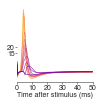

In [9]:
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0],
           expt.get_bout_win('R','Keyboard')[1]]

sweepdur = 0.05
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values 
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);


# ax.vlines(4.5,15,20)
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(0,50)
ax.set_yticks([15,20])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('Time after stimulus (ms)');



figsave(figure_folder,'Fig5_ExampleDGRCwavs')

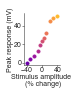

In [20]:
dt = expt.get_dt('lowgain')

amp = []
searchinds = xtime>1.5
for sweep in trialmat.T:
#     r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
#     amp.append(r_u[1])
    maxR = sweep[searchinds][np.argmax(sweep[searchinds])]
    amp.append(maxR)
amp = np.asarray(amp)

stim_ampshift = np.unique(trial_df['ampshift'])


figsize=[1,1.2]
hfig = plt.figure(figsize = figsize) 
ax = hfig.add_axes([0.3,0.3,0.5,0.6])

colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
i=0
for s,r in zip(stim_ampshift,reversed(amp)):
    ax.scatter(s,r,color = colinds[i], s=10)
    i+=1
ax.set_xlim(-47,47)
xticks([-40,0,40]);
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.9)
ax.set_ylabel('Peak response (mV)');
sns.despine(hfig)

figsave(figure_folder,'Fig5_ExampleDGRCscatter')

## SGC '20200607_000'

In [15]:
exptname = '20200607_000'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

/Users/kperks/mnt/engram_share/home/kep2142/spikedata/data_raw/20200607/20200607_000.smr


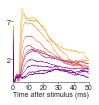

In [16]:
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

bout_uc = [expt.get_bout_win('R','Keyboard')[1],
          expt.get_bout_win('R','Keyboard')[2]]

sweepdur = 0.05
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);

# ax.vlines(4.5,2,7)
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(0,50)
ax.set_yticks([2,7])
ax.set_ylim(-1,9)
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('Time after stimulus (ms)');

figsave(figure_folder,'Fig5_ExampleSGRCwavs')

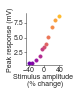

In [17]:
dt = expt.get_dt('lowgain')

amp = []
searchinds = xtime>1.5
for sweep in trialmat.T:
#     r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
#     amp.append(r_u[1])
    maxR = sweep[searchinds][np.argmax(sweep[searchinds])]
    amp.append(maxR)
amp = np.asarray(amp)

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>-20

figsize=[1,1.2]
hfig = plt.figure(figsize = figsize) 
ax = hfig.add_axes([0.3,0.3,0.5,0.6])
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
i = 0
for s,r in zip(stim_ampshift,reversed(amp)):
    ax.scatter(s,r,color = colinds[i], s=10)
    i+=1
ax.set_xlim(-47,47)
xticks([-40,0,40]);
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.9)
ax.set_ylabel('Peak response (mV)');
sns.despine(hfig)

figsave(figure_folder,'Fig5_ExampleSGRCscatter')

## SGC '20200718_000'

In [10]:
exptname = '20200718_000'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

/Users/kperks/mnt/OneDrive - wesleyan.edu/Research/Manuscripts/GRC_PerksSawtell/AcceptedRevision_CellReports/data_raw/20200718_000.smr


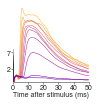

In [11]:
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

bout_uc = [expt.get_bout_win('R','Keyboard')[0],
          expt.get_bout_win('R','Keyboard')[1]]

sweepdur = 0.05
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime,sweep,color = colinds[i],lw = 0.5);

# ax.vlines(4.5,2,7)
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(0,50)
ax.set_yticks([2,7])
ax.set_ylim(-2,21)
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('Time after stimulus (ms)');

figsave(figure_folder,'Fig5_ExampleSGRCwavs_cell2')

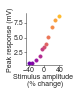

In [17]:
dt = expt.get_dt('lowgain')

amp = []
searchinds = xtime>1.5
for sweep in trialmat.T:
#     r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
#     amp.append(r_u[1])
    maxR = sweep[searchinds][np.argmax(sweep[searchinds])]
    amp.append(maxR)
amp = np.asarray(amp)

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>-20

figsize=[1,1.2]
hfig = plt.figure(figsize = figsize) 
ax = hfig.add_axes([0.3,0.3,0.5,0.6])
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
i = 0
for s,r in zip(stim_ampshift,reversed(amp)):
    ax.scatter(s,r,color = colinds[i], s=10)
    i+=1
ax.set_xlim(-47,47)
xticks([-40,0,40]);
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.9)
ax.set_ylabel('Peak response (mV)');
sns.despine(hfig)

figsave(figure_folder,'Fig5_ExampleSGRCscatter')

# Import data for simulations

20200129(blue) has a total of 11 afferents recorded
20200204(orange) has a total of 11 afferents recorded
20200531(brown) has a total of 27 afferents recorded
20200621(green) has a total of 15 afferents recorded
number afferents excluded because first fsl threshold too high or could not be fit: 3
number afferents included (spike thresh at least 0%): 61
        exptname    animal   stretch       tau    offset    max_fsl  \
1   20200129_003  20200129  5.002921 -0.017816  1.000000   9.532944   
4   20200129_006  20200129  5.715809 -0.022154  1.000000   9.858215   
7   20200129_009  20200129  5.451725 -0.015384  1.000000   9.357798   
10  20200129_012  20200129  6.623366 -0.019459  1.000000  12.010008   
1   20200531_001  20200531  6.964934 -0.020705  1.000000  11.347565   
7   20200531_007  20200531  3.842939 -0.038101  2.673761  11.087392   

           sse   df  
1   103.435863   94  
4    48.310496  108  
7    43.739012   40  
10   91.976468   85  
1    56.609527  105  
7   109.099794 

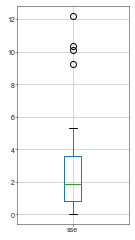

In [8]:
exptdate = 'all'
# meta_df.to_csv('DF_AfferentPopulation_' + exptdate + '.csv')
meta_df = pd.read_csv(top_dir / ('data_processed/DF_AfferentPopulation_' + exptdate + '.csv'))

meta_params_df,expt_excluded = exclude_HighThreshAff(meta_df)

well_fit,un_fit = assess_fits(meta_params_df)

# meta_params_df = meta_params_df.dropna()
data_df = well_fit
dataset = list(zip(
    data_df['stretch'],
    data_df['tau'],
    data_df['offset'],
    data_df['max_fsl']
    ))
dataset = np.asarray(dataset)
# dataset = dataset[:,0:3]

rv = gaussian_kde(dataset[:,0:3].T)

max_fsl_global = np.max(meta_params_df['max_fsl'])

# plot_corr_matrix_multigauss(rv)
filtered_df = meta_df[meta_df.exptname.str.match('|'.join(well_fit.exptname.values))]

In [9]:
## load multispike metadata

meta_df = pd.read_csv(top_dir / 'data_processed/DF_Afferent_MultiSpikePop_ALL.csv')

meta_df.head()

,Unnamed: 0,time,code,ampshift,s0t,s0a,s1t,s1a,s2t,s2a,s3t,s3a,animalID,exptname
0,5,1.885168,T,30.0,3.205342,17.364502,NaN,NaN,NaN,NaN,NaN,NaN,20200129,20200129_002
1,7,2.278948,T,10.0,3.981636,15.441895,NaN,NaN,NaN,NaN,NaN,NaN,20200129,20200129_002
2,9,2.672728,T,-20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20200129,20200129_002
3,11,3.066488,T,-40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20200129,20200129_002
4,13,3.460268,T,-10.0,5.734558,15.502930,NaN,NaN,NaN,NaN,NaN,NaN,20200129,20200129_002


In [10]:
x = np.asarray([-40,-30,-20,-10,-5,0,5,10,20,30,40])
n_inputs = 4

# Example model waveforms

## initialize model

In [11]:
## set up stimamp values
N_inputs = 4
N_runs = 1

x = np.asarray([-40,-30,-20,-10,-5,0,5,10,20,30,40])

meta_params = {
    'N_inputs' : N_inputs*4, # 7 inputs with 4 possible spikes each
    'N_runs' : N_runs,
    'duration' : 0.05*second,
    'onset_offset' : 0, # 5msec is for figure making because data plotted with 5msec pre-stimonset #4.5,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,#ms, time of normal stimulus onset relative to cmd
    'e_lmi_delay' : 4*ms #ms
}

invpeak = (meta_params['tau_e2'] / meta_params['tau_e1']) ** \
        (meta_params['tau_e1'] / (meta_params['tau_e2'] - meta_params['tau_e1']))

namespace_sim = {
    'sim_dt' : 0.1*ms,
    'Cm' : 6*pF,
    'E_l' : -70*mV,
    'g_l' : 1*nS, # a 1MOhm cell has gl = 1*nS
    'E_e' : 0*mV,
    'E_e_lmi' : -90*mV,
    'V_th' : 0*mV,
    'V_r' : -70*mV,
    'w_e' : 0.1*nS,
    'w_e_lmi' : 4*nS, #0*nS,##0,#either on and off... weight by logistic 0*nS,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,
    'tau_e_lmi' : 5*ms,
    'invpeak' : invpeak
}


get an afferent set

In [13]:


### subsample from data

meta_params['e_lmi_delay']=4*ms #ms
    
net = initialize_model(namespace_sim,meta_params) 
#initialized with max inputs going to test so don't have to recreate
net.store('intialized',filename=sim_filepath) 

multispike = get_afferents_subsampled(meta_df,N_inputs)



OR Load Pre-existing afferent set:


In [14]:
# multispike = np.load(figure_folder / 'ExampleModelResponses_0_MultispikeInputTimes',multispike,allow_pickle=False)
multispike_example_input = np.load(top_dir / 'data_processed/ExampleModelResponses_0_MultispikeInputTimes.npy')
multispike = multispike_example_input
# /Users/kperks/mnt/engram_share/locker/GranularCellPaperResources/Figure_RawEPScomponents/ExampleModelResponses_0_MultispikeInputTimes.npy

In [15]:
#if need to get fsls... can reshape each pop response to stim by doing... then getting first val in each row
np.shape(multispike_example_input[10].reshape(4,-1)) 

(4, 4)

first get reponses without inhibition for this set of afferents
calculate the amp and sum at lmi onset

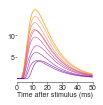

In [16]:
namespace_sim['w_e_lmi'] = 0*nS
namespace_sim['Cm'] = 12*pF
### subsample from data
net = initialize_model(namespace_sim,meta_params) 
#initialized with max inputs going to test so don't have to recreate
net.store('intialized',filename=sim_filepath) 

R_wav = []
for _,y in enumerate(multispike):
    net.restore('intialized',filename=sim_filepath) # this resets simulation clock to 0
        # the state of the system at time of restore should affect the network operation accordingly

    y = y[~np.isnan(y)] # remove nan values from array of spike times
    spk_t_aff = np.asarray(y)*ms # create spike time array for SpikeGeneratorGroup, sorted
    ind_aff = np.empty(0) # create default afferent index array in case all were nan

    spk_t_lmi = np.empty(0)*ms # create default lmi spike time in case where no afferent input (all nan)
    ind_lmi = np.empty(0) # create default lmi index array in case all were nan

    if len(y)!=0: # if not all were nan, create index array for afferent spikes, lmi neuron, and lmi spike
        ind_aff = np.arange(len(y))
        ind_lmi = np.arange(1)
        spk_t_lmi = [np.min(y)]*ms

    # update SpikeGeneratorGroup neuron indices and spikes
    net['aff_input'].set_spikes(ind_aff,spk_t_aff)
    net['lmi_input'].set_spikes(ind_lmi,spk_t_lmi)

    net.run(duration = meta_params['duration'])

    r =net['state_mon'].v/mV+70 # set r to voltage trace from simulation trial
    R_wav.append(r)
    
    xtime = net['state_mon'].t
    
#     if len(y)>0:
#         print(_)
#         print(np.sum(r[0,argmin((np.min(y))>(xtime/ms)):argmin((np.min(y)+4)>(xtime/ms))].T))
#         print(np.max(r[0,argmin((np.min(y))>(xtime/ms)):argmin((np.min(y)+4)>(xtime/ms))].T))
    

R_wav = (np.asarray(R_wav).squeeze())

colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
order = np.linspace(10,0,11)
hfig,ax = create_fig()
# plt.figure()
for i,w in enumerate(R_wav):
    ax.plot(xtime*1000,w,color=colinds[i],zorder=order[i],linewidth=0.5);
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(0,50)
ax.set_yticks([5,10])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('Time after stimulus (ms)');
    
    
figsave(figure_folder,'Fig5_ExampleModelResponses_0_NoInhib_Cm12pF')

[  0.           6.68251639  22.23362903  57.15736409  75.72267638
 107.01673981 128.65489881 144.76788667 168.0808483  180.96633829
 197.25074787]


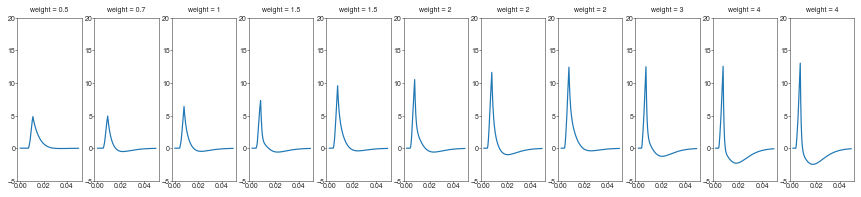

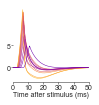

In [17]:
meta_params ['e_lmi_delay'] = 4*ms #ms

namespace_sim ['Cm'] = 6*pF

w = [0.5,0.7,1,1.5,1.5,2,2,2,3,4,4]
    
R_wav = [] # initialize array to store the result of each run


for w_,y in zip(w,multispike):
#         print(t_,w_)
    namespace_sim['w_e_lmi'] = w_*nS
    
    net = initialize_model(namespace_sim,meta_params) 
    #initialized with max inputs going to test so don't have to recreate
    net.store('intialized',filename=sim_filepath) 
    
    # y = multispike[ampind,:]
    y = y[~np.isnan(y)] # remove nan values from array of spike times
    spk_t_aff = np.asarray(y)*ms # create spike time array for SpikeGeneratorGroup, sorted
    ind_aff = np.empty(0) # create default afferent index array in case all were nan

    spk_t_lmi = np.empty(0)*ms # create default lmi spike time in case where no afferent input (all nan)
    ind_lmi = np.empty(0) # create default lmi index array in case all were nan

    if len(y)!=0: # if not all were nan, create index array for afferent spikes, lmi neuron, and lmi spike
        ind_aff = np.arange(len(y))
        ind_lmi = np.arange(1)
        spk_t_lmi = [np.min(y)]*ms

    # update SpikeGeneratorGroup neuron indices and spikes
    net['aff_input'].set_spikes(ind_aff,spk_t_aff)
    net['lmi_input'].set_spikes(ind_lmi,spk_t_lmi)

    net.run(duration = meta_params['duration'])

    r =net['state_mon'].v/mV+70 # set r to voltage trace from simulation trial

    R_wav.append(r)
#             r = r.reshape(-1)

# containers for storing across different inhib and afferent input params:
# R_amp_mat.append(np.nanmean(R_amp,1)) # append the average across runs for these #aff and this inhib delay
# R_amp_mat_subsamp = np.asarray(R_amp_mat)\

# R_wav = np.asarray(R_wav).reshape(11,-1).T
xtime = net['state_mon'].t
R_wav = (np.asarray(R_wav).squeeze())

hfig,ax = plt.subplots(1,len(w),figsize=(15,3))

_ = 0
for j,w_ in enumerate(w):
    ax[j].plot(xtime,R_wav[_,:])
    ax[j].set_ylim(-5,20)
#     ax[j].vlines(np.min(y)/1000,0,15)
#     ax[j].vlines((np.min(y)+4)/1000,0,15)
    _+=1
    ax[j].set_title('weight = ' + str(w_))

figsave(figure_folder,'Fig5_ExampleModelResponses_0_Inhib_ByWeightLMI')
#     
print(np.sum(R_wav[:,argmin((np.min(y))>(xtime/ms)):argmin((np.min(y)+4)>(xtime/ms))].T,0))

colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
order = np.linspace(10,0,11)
hfig,ax = create_fig()
for i,w in enumerate(R_wav):
    ax.plot(xtime*1000,w,color=colinds[i],zorder=order[i],linewidth=0.5);
    
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(0,50)
ax.set_yticks([0,5])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('Time after stimulus (ms)');
    
figsave(figure_folder,'Fig5_ExampleModelResponses_0_Inhib')

In [322]:
## Use this function to save a different example set of inputs
# np.save('filepath to save',multispike,allow_pickle=False)

# Plot sample afferent input tuning curves for each condition

In [20]:
results_path = top_dir / 'data_processed'

In [21]:
size_dict = {
    '1' : 10,
    '2' : 30,
    '3' : 50,
    '4' : 70,
    '5' : 90
}

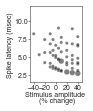

In [22]:
# multispike,fsl = get_afferents_subsampled(n_inputs)
# np.save(results_path / 'multispike_sub_4.npy', multispike)
multispike = np.load(results_path / 'multispike_sub_4.npy')

color = 'black'

# maxnumaff = 1
df = pd.DataFrame(np.round(multispike,1).T,columns=[x])

dfmelted = pd.melt(df,value_vars=[x],var_name = 'stimamp', value_name='latency')

df_plot = dfmelted.groupby(dfmelted.columns.tolist(),as_index=False).size()
df_plot['size']=df_plot['size'].astype('str')

# hfig,ax = create_fig_tuning()
# [ax.scatter(x_.repeat(4*n_inputs),y_,color='white',alpha=0.25,
#            s=10,edgecolors='purple') for x_,y_ in zip(x,multispike_homogisi)];
hfig,ax = create_fig_tuning()
sns.scatterplot(x="stimamp", y="latency", size="size",
            sizes=size_dict, alpha=.5, color=color,
            ax=ax, legend=False, data=df_plot)

ax.set_ylim(1.5,12)
ax.set_ylabel('Spike latency (msec)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);


figsave(figure_folder,'Fig5_ModelSimulation_AfferentInputPop_subsamp4')

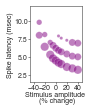

In [228]:
# multispike = generate_y_fit_multispike_homogisi(x,n_inputs,dataset,rv)
# np.save(results_path / 'multispike_homogisi.npy', multispike)
multispike = np.load(results_path / 'multispike_homogisi.npy')

color = 'purple'

df = pd.DataFrame(np.round(multispike,1).T,columns=[x])

dfmelted = pd.melt(df,value_vars=[x],var_name = 'stimamp', value_name='latency')

df_plot = dfmelted.groupby(dfmelted.columns.tolist(),as_index=False).size()

df_plot['size']=df_plot['size'].astype('str')

# hfig,ax = create_fig_tuning()
# [ax.scatter(x_.repeat(4*n_inputs),y_,color='white',alpha=0.25,
#            s=10,edgecolors='purple') for x_,y_ in zip(x,multispike_homogisi)];
hfig,ax = create_fig_tuning()
sns.scatterplot(x="stimamp", y="latency", size="size",
            sizes=size_dict, alpha=.5, color=color,
            ax=ax, legend=False, data=df_plot)

ax.set_ylim(1.5,12)
ax.set_ylabel('Spike latency (msec)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
figsave(figure_folder,'Fig5_ModelSimulation_AfferentInputPop_homogisi')

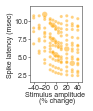

In [231]:
multispike,fsl = generate_y_fit_multispike_gauss(x,n_inputs,dataset,rv)
np.save(results_path / 'multispike_homogpspike.npy', multispike)

multispike = np.load(results_path / 'multispike_homogpspike.npy')

color = 'orange'

df = pd.DataFrame(np.round(multispike,1).T,columns=[x])

dfmelted = pd.melt(df,value_vars=[x],var_name = 'stimamp', value_name='latency')

df_plot = dfmelted.groupby(dfmelted.columns.tolist(),as_index=False).size()

df_plot['size']=df_plot['size'].astype('str')

# hfig,ax = create_fig_tuning()
# [ax.scatter(x_.repeat(4*n_inputs),y_,color='white',alpha=0.25,
#            s=10,edgecolors='purple') for x_,y_ in zip(x,multispike_homogisi)];
hfig,ax = create_fig_tuning()
sns.scatterplot(x="stimamp", y="latency", size="size",
            sizes=size_dict, alpha=.5, color=color,
            ax=ax, legend=False, data=df_plot)

ax.set_ylim(1.5,12)
ax.set_ylabel('Spike latency (msec)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
figsave(figure_folder,'Fig5_ModelSimulation_AfferentInputPop_homogpspike')



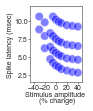

In [232]:
multispike,fsl = generate_y_fit_multispike_homog(x,n_inputs,dataset,rv)

np.save(results_path / 'multispike_homog.npy', multispike)

multispike = np.load(results_path / 'multispike_homog.npy')

color = 'blue'

df = pd.DataFrame(np.round(multispike,1).T,columns=[x])

dfmelted = pd.melt(df,value_vars=[x],var_name = 'stimamp', value_name='latency')

df_plot = dfmelted.groupby(dfmelted.columns.tolist(),as_index=False).size()

df_plot['size']=df_plot['size'].astype('str')

# hfig,ax = create_fig_tuning()
# [ax.scatter(x_.repeat(4*n_inputs),y_,color='white',alpha=0.25,
#            s=10,edgecolors='purple') for x_,y_ in zip(x,multispike_homogisi)];
hfig,ax = create_fig_tuning()
sns.scatterplot(x="stimamp", y="latency", size="size",
            sizes=size_dict, alpha=.5, color=color,
            ax=ax, legend=False, data=df_plot)

ax.set_ylim(1.5,12)
ax.set_ylabel('Spike latency (msec)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
figsave(figure_folder,'Fig5_ModelSimulation_AfferentInputPop_homogall')



# Model DGC

## Initialize

In [23]:
meta_params = {
    'N_inputs' : n_inputs*4, # 7 inputs with 4 possible spikes each
    'N_runs' : 100,
    'duration' : 0.05*second,
    'onset_offset' : 0, # 5msec is for figure making because data plotted with 5msec pre-stimonset #4.5,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,#ms, time of normal stimulus onset relative to cmd
    'e_lmi_delay' : 4*ms #ms
}

invpeak = (meta_params['tau_e2'] / meta_params['tau_e1']) ** \
        (meta_params['tau_e1'] / (meta_params['tau_e2'] - meta_params['tau_e1']))

namespace_sim = {
    'sim_dt' : 0.1*ms,
    'Cm' : 6*pF,
    'E_l' : -70*mV,
    'g_l' : 1*nS, # a 1MOhm cell has gl = 1*nS
    'E_e' : 0*mV,
    'E_e_lmi' : -90*mV,
    'V_th' : 0*mV,
    'V_r' : -70*mV,
    'w_e' : 0.1*nS,
    'w_e_lmi' : 5*nS, #0*nS,##0,#either on and off... weight by logistic 0*nS,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,
    'tau_e_lmi' : 5*ms,
    'invpeak' : invpeak
}



## Do all 4 model conditions

In [234]:
n_runs = 100
subsamp, homog_all, homog_isi, homog_pspike = run_4_model_conditions(x, n_runs, n_inputs)

In [242]:
homog_pspike

{'amp': array([[ 2.82613441,  4.64370549,  8.39206015, ...,  0.        ,
          0.        ,  0.        ],
        [ 6.07879702,  5.5813473 ,  9.50008967, ...,  7.31562706,
         12.00044691,  0.        ],
        [ 6.85622798, 11.00529536, 10.74602919, ...,  6.3339422 ,
         13.3528154 , 11.03439812],
        ...,
        [11.86757475, 13.85390868, 12.95369835, ..., 12.4738864 ,
         15.4086111 , 11.81820399],
        [11.87399865, 14.18381719, 12.80169256, ..., 13.87994404,
         15.90947877, 12.90485362],
        [12.32291842, 14.64783683, 13.16323994, ..., 14.66751725,
         15.55613922, 14.04648338]]),
 'dvdt': array([[0.7065336 , 1.16092637, 2.09801504, ...,        nan,        nan,
                nan],
        [1.51969925, 1.39533683, 2.37502242, ..., 1.82890677, 3.00011173,
                nan],
        [1.714057  , 2.75132384, 2.6865073 , ..., 1.58348555, 3.33820385,
         2.75859953],
        ...,
        [2.96689369, 3.46347717, 3.23842459, ..., 3.11847

## Plot results

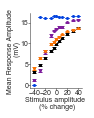

In [244]:
### plot all 4 conditions overlaid

hfig,ax = create_fig_tuning()
ax.set_ylabel('Mean Response Amplitude \n (mV)',linespacing=0.9)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.9)
# ax.set_ylim(-5,105)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);


plt.errorbar(x,
             np.mean(subsamp['amp'],1),
             yerr=stats.sem(subsamp['amp'],1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['black'], capsize=2)

plt.errorbar(x,
             np.mean(homog_all['amp'],1),
             yerr=stats.sem(homog_all['amp'],1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['blue'], capsize=2,zorder=3)

plt.errorbar(x,
             np.mean(homog_isi['amp'],1),
             yerr=stats.sem(homog_isi['amp'],1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['purple'], capsize=2,zorder=3)

plt.errorbar(x,
             np.mean(homog_pspike['amp'],1),
             yerr=stats.sem(homog_pspike['amp'],1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['orange'], capsize=2,zorder=3)


sns.despine(hfig)
figsave(figure_folder,'Fig5_ModelSimulation_AllFourConditions_DGC')

# Model SGC

## Initialize

In [11]:
meta_params = {
    'N_inputs' : n_inputs*4, # 7 inputs with 4 possible spikes each
    'N_runs' : 100,
    'duration' : 0.05*second,
    'onset_offset' : 0, # 5msec is for figure making because data plotted with 5msec pre-stimonset #4.5,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,#ms, time of normal stimulus onset relative to cmd
    'e_lmi_delay' : 4*ms #ms
}

invpeak = (meta_params['tau_e2'] / meta_params['tau_e1']) ** \
        (meta_params['tau_e1'] / (meta_params['tau_e2'] - meta_params['tau_e1']))

namespace_sim = {
    'sim_dt' : 0.1*ms,
    'Cm' : 12*pF, #12*pF,
    'E_l' : -70*mV,
    'g_l' : 1*nS, # a 1MOhm cell has gl = 1*nS
    'E_e' : 0*mV,
    'E_e_lmi' : -90*mV,
    'V_th' : 0*mV,
    'V_r' : -70*mV,
    'w_e' : 0.1*nS,
    'w_e_lmi' : 0*nS, #0*nS,##0,#either on and off... weight by logistic 0*nS,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,
    'tau_e_lmi' : 5*ms,
    'invpeak' : invpeak
}



In [249]:
n_runs = 100
subsamp, homog_all, homog_isi, homog_pspike = run_4_model_conditions(x, n_runs, n_inputs)

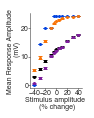

In [250]:
### plot all 4 conditions overlaid

hfig,ax = create_fig_tuning()
ax.set_ylabel('Mean Response Amplitude \n (mV)',linespacing=0.9)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.9)
# ax.set_ylim(-5,105)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);


plt.errorbar(x,
             np.mean(subsamp['amp'],1),
             yerr=stats.sem(subsamp['amp'],1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['black'], capsize=2)

plt.errorbar(x,
             np.mean(homog_all['amp'],1),
             yerr=stats.sem(homog_all['amp'],1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['blue'], capsize=2,zorder=3)

plt.errorbar(x,
             np.mean(homog_isi['amp'],1),
             yerr=stats.sem(homog_isi['amp'],1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['purple'], capsize=2,zorder=3)

plt.errorbar(x,
             np.mean(homog_pspike['amp'],1),
             yerr=stats.sem(homog_pspike['amp'],1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['orange'], capsize=2,zorder=3)

sns.despine(hfig)
figsave(figure_folder,'Fig5_ModelSimulation_AllFourConditions_SGC_12pF')

# analyze simulation results from RunSimulation_hyperparameterize.py that saved results to h5

In [25]:
def get_response_amp_atdelay(results,results_onset,lmi_delay):
    amp = []
    for i,rmat in enumerate(np.moveaxis(results, [0, 1, 2], [-1, -2, -3])):
        rmat = rmat.T
        ronset = results_onset[:,i]

        t0ind = np.array([np.argmax(xtime>=r) for r in ronset]).astype('float')
        t0ind[t0ind==0] = np.nan
        tind = np.array([np.argmax(xtime>=(r+lmi_delay)) for r in ronset]).astype('float')
        tind[tind==0] = np.nan

        amp_ = []
        for o,t,r in zip(t0ind,tind,rmat):
            if np.isnan(o):
                amp_.append(0)
            if ~np.isnan(o):
                amp_.append(r[int(t)]-r[int(o)])
        amp.append(np.array(amp_).T)
    amp = np.array(amp).T
    return amp

def get_response_amp_peak(results):
    amp = []
    for rmat in np.moveaxis(results, [0, 1, 2], [-1, -2, -3]):
        amp_ = [np.max(r)-r[0] for r in rmat.T]
        amp.append(np.array(amp_).T)
    amp = np.array(amp).T
    return amp

In [24]:
results_path = top_dir / 'data_processed'
results_path = results_path / 'simulation_results_4inputs.h5'


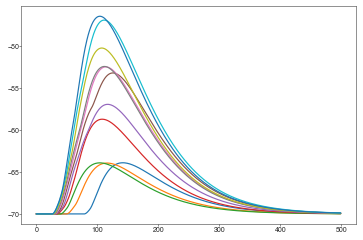

In [28]:
with h5py.File(results_path, 'a') as h5file:
    group = h5file.get('results')
    randtrial = randint(np.shape(np.array(group['subsamp']))[2])
    plt.plot(np.array(group['subsamp'])[:,:,randtrial].T);

In [29]:
h5file = h5py.File(results_path, 'r')


print(list(h5file['results'].keys()))

xtime = np.array(h5file['metadata']['xtime'])
x = np.array(h5file['metadata']['stimamp'])
subsamp = np.array(h5file['results']['subsamp'])

subsamp = np.array(h5file['results']['subsamp'])
homog_isi = np.array(h5file['results']['homog_isi'])
homog_pspike = np.array(h5file['results']['homog_pspike'])
homog_all = np.array(h5file['results']['homog_all'])

subsamp_onset = np.array(h5file['results']['subsamp_onset'])
homog_isi_onset = np.array(h5file['results']['homog_isi_onset'])
homog_pspike_onset = np.array(h5file['results']['homog_pspike_onset'])
homog_all_onset = np.array(h5file['results']['homog_all_onset'])

print(list(h5file['metadata'].keys()))

xtime = np.array(h5file['metadata']['xtime'])
stimamp = np.array(h5file['metadata']['stimamp'])

h5file.close()

['homog_all', 'homog_all_onset', 'homog_isi', 'homog_isi_onset', 'homog_pspike', 'homog_pspike_onset', 'subsamp', 'subsamp_onset']
['n_inputs', 'n_runs', 'stimamp', 'xtime']


In [18]:
np.shape(homog_isi)

(11, 500, 200)

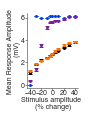

In [28]:
lmi_delay = 2


hfig,ax = create_fig_tuning()
ax.set_ylabel('Mean Response Amplitude \n (mV)',linespacing=0.9)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.9)
# ax.set_ylim(0,17)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);

amp = get_response_amp_atdelay(subsamp,subsamp_onset,lmi_delay)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1,nan_policy='omit'),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['black'], capsize=2)

amp = get_response_amp_atdelay(homog_all,homog_all_onset,lmi_delay)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1,nan_policy='omit'),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['blue'], capsize=2,zorder=3)

amp = get_response_amp_atdelay(homog_isi,homog_isi_onset,lmi_delay)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1,nan_policy='omit'),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['purple'], capsize=2,zorder=3)

amp = get_response_amp_atdelay(homog_pspike,homog_pspike_onset,lmi_delay)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1,nan_policy='omit'),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['orange'], capsize=2,zorder=3)


sns.despine(hfig)
figsave(figure_folder,'Fig5_ModelSimulation_AllFourConditions_DGC_2msecLMI')


<ErrorbarContainer object of 3 artists>

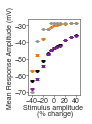

In [295]:

hfig,ax = create_fig_tuning()
ax.set_ylabel('Mean Response Amplitude (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
# ax.set_ylim(-5,105)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);

amp = get_response_amp_peak(subsamp)
plt.errorbar(x,
             np.mean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['black'], capsize=2)

amp = get_response_amp_peak(homog_isi)
plt.errorbar(x,
             np.mean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['purple'], capsize=2)

amp = get_response_amp_peak(homog_pspike)
plt.errorbar(x,
             np.mean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['orange'], capsize=2)

amp = get_response_amp_peak(homog_all)
plt.errorbar(x,
             np.mean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['grey'], capsize=2)

### add no stimamp latency tuning condition

In [377]:
def generate_y_fit_multispike_nolatencytuning_pspikevar(x,n_inputs,dataset,rv):
    jitter_amp = 0.1 #(max jitter amp)
    mean_val = 2
    minfsl = np.array([mean_val+random.uniform(-jitter_amp,jitter_amp)]).repeat(11,-1)
    offset_2 = 1.74 #(these are averages from empirical data in ms from first spikes)
    offset_3 = 3.66
    offset_4 = 6.37
    t2 = minfsl + offset_2
    t3 = minfsl + offset_3
    t4 = minfsl + offset_4
    basis = np.vstack([minfsl,t2,t3,t4]).T
    
    # select a subset of real afferent p(spike) to mimic
    subset = random.choices(np.unique(meta_df['exptname']),k=n_inputs) #divide by 4 if multispike
    multispike = []
    # get spike times across stimamps
    for expt_ in subset:
        spkt = meta_df[meta_df['exptname'].isin([expt_])].groupby(['ampshift']).mean()[['s0t','s1t','s2t','s3t']].values
        spk_mask = np.isnan(spkt)
        y = basis.copy()
        y[spk_mask] = np.nan
        multispike.extend(y.T)
    multispike = np.asarray(multispike).T
    
    return multispike
    


In [380]:
multispike = generate_y_fit_multispike_nolatencytuning_pspikevar(x,n_inputs,dataset,rv)

In [378]:
a = 4


n_runs = 50
n_inputs_list = [4,5,6,7]
x = np.asarray([-40,-30,-20,-10,-5,0,5,10,20,30,40])
sim_dt = 0.1
# xtime = np.linspace(0,50,int(0.05/sim_dt*1000))

meta_params = {
    'N_inputs' : a*4, # 7 inputs with 4 possible spikes each
    'N_runs' : n_runs,
    'duration' : 0.05*second,
    'onset_offset' : 0, # 5msec is for figure making because data plotted with 5msec pre-stimonset #4.5,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,#ms, time of normal stimulus onset relative to cmd
    'e_lmi_delay' : 4*ms #ms
}

invpeak = (meta_params['tau_e2'] / meta_params['tau_e1']) ** \
        (meta_params['tau_e1'] / (meta_params['tau_e2'] - meta_params['tau_e1']))

namespace_sim = {
    'sim_dt' : sim_dt*ms,
    'Cm' : 6*pF,
    'E_l' : -70*mV,
    'g_l' : 1*nS, # a 1MOhm cell has gl = 1*nS
    'E_e' : 0*mV,
    'E_e_lmi' : -90*mV,
    'V_th' : 0*mV,
    'V_r' : -70*mV,
    'w_e' : 0.1*nS,
    'w_e_lmi' : 0*nS, #0*nS,##0,#either on and off... weight by logistic 0*nS,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,
    'tau_e_lmi' : 5*ms,
    'invpeak' : invpeak
}


filename = 'simulation_results_'+ str(a) + 'inputs_nolatencytuning.h5'
model_h5_resultspath = savepath / filename

meta_params['N_inputs'] = a*4

with h5py.File(model_h5_resultspath, 'a') as h5file:
    group = h5file.require_group('results')
    group = h5file.require_group('metadata')
    group.create_dataset('stimamp',data=x)
    # group.create_dataset('xtime',data=xtime) # get this from subsamp simulation
    group.create_dataset('n_inputs',data=a)
    group.create_dataset('n_runs',data=n_runs)

############# def run_4_model_conditions(x, n_runs, n_inputs):
# get a canonical multispike tuning function from fsl generative model and offsets with basic spike threshold at 12ms

net = initialize_model(namespace_sim,meta_params) 
net.store('intialized',filename=sim_filepath) 

R_wavs = []
onset = []
print('doing no latency tuning (only p_spike) simulation')
for _ in tqdm(range(n_runs)):

    # get spike times for afferent population
    multispike = generate_y_fit_multispike_nolatencytuning_pspikevar(x,n_inputs,dataset,rv)

    R_wavs_ = [] # initialize array to store responses across stimulus set
    onset_ = []
    for y in multispike:
        miny = np.NaN
        net.restore('intialized',filename=sim_filepath) # this resets simulation clock to 0
            # the state of the system at time of restore should affect the network operation accordingly
        y = y[~np.isnan(y)] # remove nan values from array of spike times
        spk_t_aff = np.asarray(y)*ms # create spike time array for SpikeGeneratorGroup, sorted
        ind_aff = np.empty(0) # create default afferent index array in case all were nan

        spk_t_lmi = np.empty(0)*ms # create default lmi spike time in case where no afferent input (all nan)
        ind_lmi = np.empty(0) # create default lmi index array in case all were nan

        if len(y)!=0: # if not all were nan, create index array for afferent spikes, lmi neuron, and lmi spike
            ind_aff = np.arange(len(y))
            ind_lmi = np.arange(1)
            spk_t_lmi = [np.min(y)]*ms
            miny = np.min(y)

        # update SpikeGeneratorGroup neuron indices and spikes
        net['aff_input'].set_spikes(ind_aff,spk_t_aff)
        net['lmi_input'].set_spikes(ind_lmi,spk_t_lmi)

        net.run(duration = meta_params['duration'])

        r =net['state_mon'].v/mV # set r to voltage trace from simulation trial
        R_wavs_.append(r.reshape(-1)) # append response for this stimamp to response mat across all stimamp
        onset_.append(miny)

    R_wavs.append(np.asarray(R_wavs_).T) #append the result from this run across stimamp
    onset.append(np.asarray(onset_).T)

R_wavs = np.asarray(R_wavs).T
onset = np.asarray(onset).T

with h5py.File(model_h5_resultspath, 'a') as h5file:
    group = h5file.get('results')
    group.create_dataset('pspike_nolattuning',data = R_wavs)
    group.create_dataset('pspike_nolattuning_onset',data = onset)

  0%|          | 0/50 [00:00<?, ?it/s]

doing no latency tuning (only p_spike) simulation


100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


In [384]:
results_path_ = top_dir / 'data_processed'
results_path = results_path_ / 'simulation_results_4inputs_nolatencytuning.h5'
# results_path = results_path_ / 'simulation_results_4inputs.h5'

In [369]:
h5file = h5py.File(results_path, 'r')

print(list(h5file['results'].keys()))
h5file.close()

['homog_all', 'homog_all_onset', 'homog_isi', 'homog_isi_onset', 'homog_pspike', 'homog_pspike_onset', 'subsamp', 'subsamp_onset']


['homog_all', 'homog_all_onset', 'homog_isi', 'homog_isi_onset', 'homog_pspike', 'homog_pspike_onset', 'subsamp', 'subsamp_onset']
175
['pspike_nolattuning', 'pspike_nolattuning_onset']
9


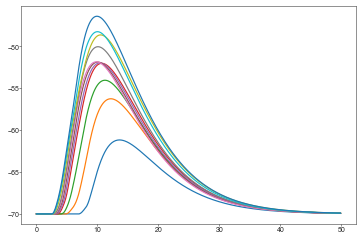

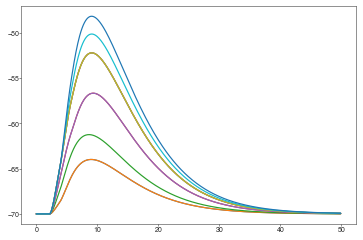

In [385]:

results_path = results_path_ / 'simulation_results_4inputs.h5'
with h5py.File(results_path, 'r') as h5file:
    group = h5file.get('results')
    print(list(h5file['results'].keys()))
    randtrial = randint(np.shape(np.array(group['subsamp']))[2])
    print(randtrial)
    plt.figure()
    plt.plot(xtime,np.array(group['subsamp'])[:,:,randtrial].T);
    
results_path = results_path_ / 'simulation_results_4inputs_nolatencytuning.h5'
with h5py.File(results_path, 'r') as h5file:
    group = h5file.get('results')
    print(list(h5file['results'].keys()))
    randtrial = randint(np.shape(np.array(group['pspike_nolattuning']))[2])
    print(randtrial)
    plt.figure()
    plt.plot(xtime,np.array(group['pspike_nolattuning'])[:,:,randtrial].T);

In [386]:
h5file = h5py.File(results_path, 'r')

print(list(h5file['results'].keys()))

homog_isi_nolattuning = np.array(h5file['results']['pspike_nolattuning'])
homog_isi_nolatshift_onset = np.array(h5file['results']['pspike_nolattuning_onset'])

# print(list(h5file['metadata'].keys()))

# xtime = np.array(h5file['metadata']['xtime'])
# stimamp = np.array(h5file['metadata']['stimamp'])

h5file.close()

['pspike_nolattuning', 'pspike_nolattuning_onset']


<ErrorbarContainer object of 3 artists>

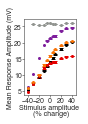

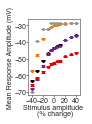

In [387]:
lmi_delay = 4

hfig,ax = create_fig_tuning()
ax.set_ylabel('Mean Response Amplitude (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
# ax.set_ylim(-5,105)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);

amp = get_response_amp_atdelay(subsamp,subsamp_onset,lmi_delay)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['black'], capsize=2)

amp = get_response_amp_atdelay(homog_isi,homog_isi_onset,lmi_delay)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['purple'], capsize=2)

amp = get_response_amp_atdelay(homog_isi_nolattuning,homog_isi_nolatshift_onset,lmi_delay)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['red'], capsize=2)


amp = get_response_amp_atdelay(homog_pspike,homog_pspike_onset,lmi_delay)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['orange'], capsize=2)

amp = get_response_amp_atdelay(homog_all,homog_all_onset,lmi_delay)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['grey'], capsize=2)


hfig,ax = create_fig_tuning()
ax.set_ylabel('Mean Response Amplitude (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
# ax.set_ylim(-5,105)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);

amp = get_response_amp_peak(subsamp)
plt.errorbar(x,
             np.mean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['black'], capsize=2)

amp = get_response_amp_peak(homog_isi)
plt.errorbar(x,
             np.mean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['purple'], capsize=2)

amp = get_response_amp_peak(homog_isi_nolattuning)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['red'], capsize=2)

amp = get_response_amp_peak(homog_pspike)
plt.errorbar(x,
             np.mean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['orange'], capsize=2)

amp = get_response_amp_peak(homog_all)
plt.errorbar(x,
             np.mean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['grey'], capsize=2)

# Make graphic of latency shift mech with inhib using model DGC 

## Initialize

In [ ]:
%matplotlib widget

In [44]:
n_inputs = 4
meta_params = {
    'N_inputs' : n_inputs*4, # 7 inputs with 4 possible spikes each
    'N_runs' : 100,
    'duration' : 0.05*second,
    'onset_offset' : 0, # 5msec is for figure making because data plotted with 5msec pre-stimonset #4.5,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,#ms, time of normal stimulus onset relative to cmd
    'e_lmi_delay' : 4*ms #ms
}

invpeak = (meta_params['tau_e2'] / meta_params['tau_e1']) ** \
        (meta_params['tau_e1'] / (meta_params['tau_e2'] - meta_params['tau_e1']))

namespace_sim = {
    'sim_dt' : 0.1*ms,
    'Cm' : 6*pF,
    'E_l' : -70*mV,
    'g_l' : 1*nS, # a 1MOhm cell has gl = 1*nS
    'E_e' : 0*mV,
    'E_e_lmi' : -90*mV,
    'V_th' : 0*mV,
    'V_r' : -70*mV,
    'w_e' : 0.1*nS,
    'w_e_lmi' : 0*nS, #0*nS,##0,#either on and off... weight by logistic 0*nS,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,
    'tau_e_lmi' : 5*ms,
    'invpeak' : invpeak
}

## Use just two inputs and do two different relative latencies

In [13]:
multispike,fsl = get_afferents_subsampled(2)

In [14]:
fsl

array([[       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [7.08681135, 7.40487316],
       [6.75500835, 6.66138184],
       [       nan, 5.99799733],
       [5.64065109, 5.57242991],
       [6.01717148, 5.16188251],
       [5.66658717, 4.3858478 ],
       [4.19449082, 3.92773698],
       [3.72843628, 3.65236983]])

In [47]:

# multispike = np.asarray([[3],[2.5],[2.25]])
multispike = np.asarray([[3.5],[3],[2.75]])

net = initialize_model(namespace_sim,meta_params) 
net.store('intialized',filename=sim_filepath) 

### subsample from data
R_wavs_ = [] # initialize array to store responses across stimulus set
onset_ = []

i = 0
for _ in tqdm(range(len(multispike))):

    # get spike times for afferent population
#     multispike,fsl = get_afferents_subsampled(a)


#     for y in multispike:
    y = multispike[i]
    i+=1
    miny = np.NaN
    net.restore('intialized',filename=sim_filepath) # this resets simulation clock to 0
        # the state of the system at time of restore should affect the network operation accordingly
    y = y[~np.isnan(y)] # remove nan values from array of spike times
    spk_t_aff = np.asarray(y)*ms # create spike time array for SpikeGeneratorGroup, sorted
    ind_aff = np.empty(0) # create default afferent index array in case all were nan

    spk_t_lmi = np.empty(0)*ms # create default lmi spike time in case where no afferent input (all nan)
    ind_lmi = np.empty(0) # create default lmi index array in case all were nan

    if len(y)!=0: # if not all were nan, create index array for afferent spikes, lmi neuron, and lmi spike
        ind_aff = np.arange(len(y))
        ind_lmi = np.arange(1)
        spk_t_lmi = [np.min(y)]*ms
        miny = np.min(y)

    # update SpikeGeneratorGroup neuron indices and spikes
    net['aff_input'].set_spikes(ind_aff,spk_t_aff)
    net['lmi_input'].set_spikes(ind_lmi,spk_t_lmi)

    net.run(duration = meta_params['duration'])

    r =net['state_mon'].v/mV # set r to voltage trace from simulation trial
    xtime = net['state_mon'].t/ms
    R_wavs_.append(r.reshape(-1)) # append response for this stimamp to response mat across all stimamp
    onset_.append(miny)


R_wavs = np.asarray(R_wavs_).T
R_wavs = R_wavs-R_wavs[0,:]
onset = np.asarray(onset_).T

plt.figure(figsize=(3,5))
colinds = plt.cm.plasma(np.linspace(0.2,0.85,3))
plt.plot(xtime, R_wavs[:,0],color=colinds[0],linestyle='-')
plt.vlines(multispike[0][0],0,5,color=colinds[0],linestyle='-')
plt.plot(xtime, R_wavs[:,1],color=colinds[1],linestyle='-')
plt.vlines(multispike[1][0],0,5,color=colinds[1],linestyle='-')
plt.plot(xtime, R_wavs[:,2],color=colinds[2],linestyle='-')
plt.vlines(multispike[2][0],0,5,color=colinds[2],linestyle='-')
plt.xlim(0,10)
plt.vlines(2,0,10,color='black',linestyle='--')
plt.vlines(5,0,15,color='blue',linestyle='--')

plt.show()



100%|██████████| 3/3 [00:00<00:00,  4.07it/s]


FigureCanvasNbAgg()

In [48]:
# multispike = np.asarray([[2,3],[2,2.5],[2,2.25]])
multispike = np.asarray([[2,3.5],[2,3],[2,2.75]])

net = initialize_model(namespace_sim,meta_params) 
net.store('intialized',filename=sim_filepath) 

### subsample from data
R_wavs_ = [] # initialize array to store responses across stimulus set
onset_ = []

i = 0
for _ in tqdm(range(len(multispike))):

    # get spike times for afferent population
#     multispike,fsl = get_afferents_subsampled(a)


#     for y in multispike:
    y = multispike[i]
    i+=1
    miny = np.NaN
    net.restore('intialized',filename=sim_filepath) # this resets simulation clock to 0
        # the state of the system at time of restore should affect the network operation accordingly
    y = y[~np.isnan(y)] # remove nan values from array of spike times
    spk_t_aff = np.asarray(y)*ms # create spike time array for SpikeGeneratorGroup, sorted
    ind_aff = np.empty(0) # create default afferent index array in case all were nan

    spk_t_lmi = np.empty(0)*ms # create default lmi spike time in case where no afferent input (all nan)
    ind_lmi = np.empty(0) # create default lmi index array in case all were nan

    if len(y)!=0: # if not all were nan, create index array for afferent spikes, lmi neuron, and lmi spike
        ind_aff = np.arange(len(y))
        ind_lmi = np.arange(1)
        spk_t_lmi = [np.min(y)]*ms
        miny = np.min(y)

    # update SpikeGeneratorGroup neuron indices and spikes
    net['aff_input'].set_spikes(ind_aff,spk_t_aff)
    net['lmi_input'].set_spikes(ind_lmi,spk_t_lmi)

    net.run(duration = meta_params['duration'])

    r =net['state_mon'].v/mV # set r to voltage trace from simulation trial
    xtime = net['state_mon'].t/ms
    R_wavs_.append(r.reshape(-1)) # append response for this stimamp to response mat across all stimamp
    onset_.append(miny)


R_wavs = np.asarray(R_wavs_).T
R_wavs = R_wavs-R_wavs[0,:]
onset = np.asarray(onset_).T

plt.figure(figsize=(3,5))
colinds = plt.cm.plasma(np.linspace(0.2,0.85,3))
plt.plot(xtime, R_wavs[:,0],color=colinds[0],linestyle='-')
plt.vlines(multispike[0][1],0,5,color=colinds[0],linestyle='-')
plt.plot(xtime, R_wavs[:,1],color=colinds[1],linestyle='-')
plt.vlines(multispike[1][1],0,5,color=colinds[1],linestyle='-')
plt.plot(xtime, R_wavs[:,2],color=colinds[2],linestyle='-')
plt.vlines(multispike[2][1],0,5,color=colinds[2],linestyle='-')
plt.xlim(0,10)
plt.vlines(2,0,10,color='black',linestyle='--')
plt.vlines(5,0,15,color='blue',linestyle='--')

plt.show()
# plt.vlines(2.5,-70,-64,color=colinds[1],linestyle='-')

100%|██████████| 3/3 [00:00<00:00,  4.08it/s]


FigureCanvasNbAgg()

In [49]:
# multispike = np.asarray([[2,2.1,3],[2,2.1,2.5],[2,2.1,2.25]])
multispike = np.asarray([[2,2.75,3.5],[2,2.75,3],[2,2.75,2.75]])

net = initialize_model(namespace_sim,meta_params) 
net.store('intialized',filename=sim_filepath) 

### subsample from data
R_wavs_ = [] # initialize array to store responses across stimulus set
onset_ = []

i = 0
for _ in tqdm(range(len(multispike))):

    # get spike times for afferent population
#     multispike,fsl = get_afferents_subsampled(a)


#     for y in multispike:
    y = multispike[i]
    i+=1
    miny = np.NaN
    net.restore('intialized',filename=sim_filepath) # this resets simulation clock to 0
        # the state of the system at time of restore should affect the network operation accordingly
    y = y[~np.isnan(y)] # remove nan values from array of spike times
    spk_t_aff = np.asarray(y)*ms # create spike time array for SpikeGeneratorGroup, sorted
    ind_aff = np.empty(0) # create default afferent index array in case all were nan

    spk_t_lmi = np.empty(0)*ms # create default lmi spike time in case where no afferent input (all nan)
    ind_lmi = np.empty(0) # create default lmi index array in case all were nan

    if len(y)!=0: # if not all were nan, create index array for afferent spikes, lmi neuron, and lmi spike
        ind_aff = np.arange(len(y))
        ind_lmi = np.arange(1)
        spk_t_lmi = [np.min(y)]*ms
        miny = np.min(y)

    # update SpikeGeneratorGroup neuron indices and spikes
    net['aff_input'].set_spikes(ind_aff,spk_t_aff)
    net['lmi_input'].set_spikes(ind_lmi,spk_t_lmi)

    net.run(duration = meta_params['duration'])

    r =net['state_mon'].v/mV # set r to voltage trace from simulation trial
    xtime = net['state_mon'].t/ms
    R_wavs_.append(r.reshape(-1)) # append response for this stimamp to response mat across all stimamp
    onset_.append(miny)


R_wavs = np.asarray(R_wavs_).T
R_wavs = R_wavs-R_wavs[0,:]
onset = np.asarray(onset_).T

plt.figure(figsize=(3,5))
colinds = plt.cm.plasma(np.linspace(0.2,0.85,3))
plt.plot(xtime, R_wavs[:,0],color=colinds[0],linestyle='-')
plt.vlines(multispike[0][2],0,5,color=colinds[0],linestyle='-')
plt.plot(xtime, R_wavs[:,1],color=colinds[1],linestyle='-')
plt.vlines(multispike[1][2],0,5,color=colinds[1],linestyle='-')
plt.plot(xtime, R_wavs[:,2],color=colinds[2],linestyle='-')
plt.vlines(multispike[2][2],0,5,color=colinds[2],linestyle='-')
plt.xlim(0,10)
plt.vlines(2,0,10,color='black',linestyle='--')
plt.vlines(5,0,15,color='blue',linestyle='--')

plt.show()
# plt.vlines(2.5,-70,-64,color=colinds[1],linestyle='-')

100%|██████████| 3/3 [00:00<00:00,  4.00it/s]


FigureCanvasNbAgg()

In [50]:
# multispike = np.asarray([[2,2.1,2.25,3],[2,2.1,2.25,2.5],[2,2.1,2.25,2.25]])
multispike = np.asarray([[2,2.75,3,3.5],[2,2.75,3,3],[2,2.75,3,2.75]])

net = initialize_model(namespace_sim,meta_params) 
net.store('intialized',filename=sim_filepath) 

### subsample from data
R_wavs_ = [] # initialize array to store responses across stimulus set
onset_ = []

i = 0
for _ in tqdm(range(len(multispike))):

    # get spike times for afferent population
#     multispike,fsl = get_afferents_subsampled(a)


#     for y in multispike:
    y = multispike[i]
    i+=1
    miny = np.NaN
    net.restore('intialized',filename=sim_filepath) # this resets simulation clock to 0
        # the state of the system at time of restore should affect the network operation accordingly
    y = y[~np.isnan(y)] # remove nan values from array of spike times
    spk_t_aff = np.asarray(y)*ms # create spike time array for SpikeGeneratorGroup, sorted
    ind_aff = np.empty(0) # create default afferent index array in case all were nan

    spk_t_lmi = np.empty(0)*ms # create default lmi spike time in case where no afferent input (all nan)
    ind_lmi = np.empty(0) # create default lmi index array in case all were nan

    if len(y)!=0: # if not all were nan, create index array for afferent spikes, lmi neuron, and lmi spike
        ind_aff = np.arange(len(y))
        ind_lmi = np.arange(1)
        spk_t_lmi = [np.min(y)]*ms
        miny = np.min(y)

    # update SpikeGeneratorGroup neuron indices and spikes
    net['aff_input'].set_spikes(ind_aff,spk_t_aff)
    net['lmi_input'].set_spikes(ind_lmi,spk_t_lmi)

    net.run(duration = meta_params['duration'])

    r =net['state_mon'].v/mV # set r to voltage trace from simulation trial
    xtime = net['state_mon'].t/ms
    R_wavs_.append(r.reshape(-1)) # append response for this stimamp to response mat across all stimamp
    onset_.append(miny)


R_wavs = np.asarray(R_wavs_).T
R_wavs = R_wavs-R_wavs[0,:]
onset = np.asarray(onset_).T

plt.figure(figsize=(3,5))
colinds = plt.cm.plasma(np.linspace(0.2,0.85,3))
plt.plot(xtime, R_wavs[:,0],color=colinds[0],linestyle='-')
plt.vlines(multispike[0][3],0,5,color=colinds[0],linestyle='-')
plt.plot(xtime, R_wavs[:,1],color=colinds[1],linestyle='-')
plt.vlines(multispike[1][3],0,5,color=colinds[1],linestyle='-')
plt.plot(xtime, R_wavs[:,2],color=colinds[2],linestyle='-')
plt.vlines(multispike[2][3],0,5,color=colinds[2],linestyle='-')
plt.xlim(0,10)
plt.vlines(2,0,10,color='black',linestyle='--')
plt.vlines(5,0,15,color='blue',linestyle='--')

plt.show()
# plt.vlines(2.5,-70,-64,color=colinds[1],linestyle='-')

100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


FigureCanvasNbAgg()

## now move all 3 by same amount relative to first

In [51]:
multispike = np.asarray([[2,2.75,3,3.5],[2,2.25,2.5,3],[2,2,2.25,2.75]])

net = initialize_model(namespace_sim,meta_params) 
net.store('intialized',filename=sim_filepath) 

### subsample from data
R_wavs_ = [] # initialize array to store responses across stimulus set
onset_ = []

i = 0
for _ in tqdm(range(len(multispike))):

    # get spike times for afferent population
#     multispike,fsl = get_afferents_subsampled(a)


#     for y in multispike:
    y = multispike[i]
    i+=1
    miny = np.NaN
    net.restore('intialized',filename=sim_filepath) # this resets simulation clock to 0
        # the state of the system at time of restore should affect the network operation accordingly
    y = y[~np.isnan(y)] # remove nan values from array of spike times
    spk_t_aff = np.asarray(y)*ms # create spike time array for SpikeGeneratorGroup, sorted
    ind_aff = np.empty(0) # create default afferent index array in case all were nan

    spk_t_lmi = np.empty(0)*ms # create default lmi spike time in case where no afferent input (all nan)
    ind_lmi = np.empty(0) # create default lmi index array in case all were nan

    if len(y)!=0: # if not all were nan, create index array for afferent spikes, lmi neuron, and lmi spike
        ind_aff = np.arange(len(y))
        ind_lmi = np.arange(1)
        spk_t_lmi = [np.min(y)]*ms
        miny = np.min(y)

    # update SpikeGeneratorGroup neuron indices and spikes
    net['aff_input'].set_spikes(ind_aff,spk_t_aff)
    net['lmi_input'].set_spikes(ind_lmi,spk_t_lmi)

    net.run(duration = meta_params['duration'])

    r =net['state_mon'].v/mV # set r to voltage trace from simulation trial
    xtime = net['state_mon'].t/ms
    R_wavs_.append(r.reshape(-1)) # append response for this stimamp to response mat across all stimamp
    onset_.append(miny)


R_wavs = np.asarray(R_wavs_).T
R_wavs = R_wavs-R_wavs[0,:]
onset = np.asarray(onset_).T

plt.figure(figsize=(3,5))
colinds = plt.cm.plasma(np.linspace(0.2,0.85,3))
plt.plot(xtime, R_wavs[:,0],color=colinds[0],linestyle='-')
plt.vlines(multispike[0][3],0,5,color=colinds[0],linestyle='-')
plt.plot(xtime, R_wavs[:,1],color=colinds[1],linestyle='-')
plt.vlines(multispike[1][3],0,5,color=colinds[1],linestyle='-')
plt.plot(xtime, R_wavs[:,2],color=colinds[2],linestyle='-')
plt.vlines(multispike[2][3],0,5,color=colinds[2],linestyle='-')
plt.xlim(0,10)
plt.vlines(2,0,10,color='black',linestyle='--')
plt.vlines(5,0,15,color='blue',linestyle='--')

plt.show()
# plt.vlines(2.5,-70,-64,color=colinds[1],linestyle='-')

100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


FigureCanvasNbAgg()

In [54]:
np.max(R_wavs,0)

array([11.42227156, 11.45383545, 11.46735578])

## make CD + EA for Figure 1

In [ ]:
# multispike = np.asarray([[2,3],[2,2.5],[2,2.25]])
multispike = np.asarray([[np.nan,5],[5,12],[5,24]])


meta_params['duration'] = 0.075*second

net = initialize_model(namespace_sim,meta_params) 
net.store('intialized',filename=sim_filepath) 

### subsample from data
R_wavs_ = [] # initialize array to store responses across stimulus set
onset_ = []

i = 0
for _ in tqdm(range(len(multispike))):

    # get spike times for afferent population
#     multispike,fsl = get_afferents_subsampled(a)


#     for y in multispike:
    y = multispike[i]
    i+=1
    miny = np.NaN
    net.restore('intialized',filename=sim_filepath) # this resets simulation clock to 0
        # the state of the system at time of restore should affect the network operation accordingly
    y = y[~np.isnan(y)] # remove nan values from array of spike times
    spk_t_aff = np.asarray(y)*ms # create spike time array for SpikeGeneratorGroup, sorted
    ind_aff = np.empty(0) # create default afferent index array in case all were nan

    spk_t_lmi = np.empty(0)*ms # create default lmi spike time in case where no afferent input (all nan)
    ind_lmi = np.empty(0) # create default lmi index array in case all were nan

    if len(y)!=0: # if not all were nan, create index array for afferent spikes, lmi neuron, and lmi spike
        ind_aff = np.arange(len(y))
        ind_lmi = np.arange(1)
        spk_t_lmi = [np.min(y)]*ms
        miny = np.min(y)

    # update SpikeGeneratorGroup neuron indices and spikes
    net['aff_input'].set_spikes(ind_aff,spk_t_aff)
    net['lmi_input'].set_spikes(ind_lmi,spk_t_lmi)

    net.run(duration = meta_params['duration'])

    r =net['state_mon'].v/mV # set r to voltage trace from simulation trial
    xtime = net['state_mon'].t/ms
    R_wavs_.append(r.reshape(-1)) # append response for this stimamp to response mat across all stimamp
    onset_.append(miny)


R_wavs = np.asarray(R_wavs_).T
R_wavs = R_wavs-R_wavs[0,:]
onset = np.asarray(onset_).T

In [26]:
# hfig,ax = create_fig()
hfig = plt.figure(figsize=[3,1])
ax = hfig.add_axes([0.2,0.2,0.7,0.7],frameon=False)
colinds = plt.cm.plasma(np.linspace(0.2,0.85,2))
plt.plot(xtime, R_wavs[:,0],color='black',linestyle='-')
plt.plot(xtime, R_wavs[:,1],color=colinds[0],linestyle='-')
plt.vlines(multispike[1][1],0,5,color=colinds[0],linestyle='-')
plt.plot(xtime, R_wavs[:,2],color=colinds[1],linestyle='-')
plt.vlines(multispike[2][1],0,5,color=colinds[1],linestyle='-')
# plt.plot(xtime, R_wavs[:,2],color=colinds[2],linestyle='-')
# plt.vlines(multispike[2][1],0,5,color=colinds[2],linestyle='-')
plt.xlim(0,60)
# plt.vlines(2,0,10,color='black',linestyle='--')
# plt.vlines(5,0,15,color='blue',linestyle='--')

plt.show()
# plt.vlines(2.5,-70,-64,color=colinds[1],linestyle='-')
figsave(figure_folder,'Fig1_HypothesisWavs')

FigureCanvasNbAgg()

## plot min psps for sgc and dgc

### dgc

In [118]:
n_inputs = 4
meta_params = {
    'N_inputs' : n_inputs*4, # 7 inputs with 4 possible spikes each
    'N_runs' : 100,
    'duration' : 0.05*second,
    'onset_offset' : 0, # 5msec is for figure making because data plotted with 5msec pre-stimonset #4.5,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,#ms, time of normal stimulus onset relative to cmd
    'e_lmi_delay' : 4*ms #ms
}

invpeak = (meta_params['tau_e2'] / meta_params['tau_e1']) ** \
        (meta_params['tau_e1'] / (meta_params['tau_e2'] - meta_params['tau_e1']))

namespace_sim = {
    'sim_dt' : 0.1*ms,
    'Cm' : 6*pF,
    'E_l' : -70*mV,
    'g_l' : 1*nS, # a 1MOhm cell has gl = 1*nS
    'E_e' : 0*mV,
    'E_e_lmi' : -90*mV,
    'V_th' : 0*mV,
    'V_r' : -70*mV,
    'w_e' : 0.1*nS,
    'w_e_lmi' : 0*nS, #0*nS,##0,#either on and off... weight by logistic 0*nS,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,
    'tau_e_lmi' : 5*ms,
    'invpeak' : invpeak
}

#### make single EA input for Supplement Fig 4

In [119]:
# multispike = np.asarray([[2,3],[2,2.5],[2,2.25]])
multispike = np.asarray([[np.nan,0]])


meta_params['duration'] = 0.075*second

net = initialize_model(namespace_sim,meta_params) 
net.store('intialized',filename=sim_filepath) 

### subsample from data
R_wavs_ = [] # initialize array to store responses across stimulus set
onset_ = []

i = 0
for _ in tqdm(range(len(multispike))):

    # get spike times for afferent population
#     multispike,fsl = get_afferents_subsampled(a)


#     for y in multispike:
    y = multispike[i]
    i+=1
    miny = np.NaN
    net.restore('intialized',filename=sim_filepath) # this resets simulation clock to 0
        # the state of the system at time of restore should affect the network operation accordingly
    y = y[~np.isnan(y)] # remove nan values from array of spike times
    spk_t_aff = np.asarray(y)*ms # create spike time array for SpikeGeneratorGroup, sorted
    ind_aff = np.empty(0) # create default afferent index array in case all were nan

    spk_t_lmi = np.empty(0)*ms # create default lmi spike time in case where no afferent input (all nan)
    ind_lmi = np.empty(0) # create default lmi index array in case all were nan

    if len(y)!=0: # if not all were nan, create index array for afferent spikes, lmi neuron, and lmi spike
        ind_aff = np.arange(len(y))
        ind_lmi = np.arange(1)
        spk_t_lmi = [np.min(y)]*ms
        miny = np.min(y)

    # update SpikeGeneratorGroup neuron indices and spikes
    net['aff_input'].set_spikes(ind_aff,spk_t_aff)
    net['lmi_input'].set_spikes(ind_lmi,spk_t_lmi)

    net.run(duration = meta_params['duration'])

    r =net['state_mon'].v/mV # set r to voltage trace from simulation trial
    xtime_model = net['state_mon'].t/ms
    R_wavs_.append(r.reshape(-1)) # append response for this stimamp to response mat across all stimamp
    onset_.append(miny)


R_wavs = np.asarray(R_wavs_).T
R_wavs = R_wavs-R_wavs[0,:]
onset = np.asarray(onset_).T

100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


In [49]:
hfig,ax = create_fig()
# hfig = plt.figure(figsize=[3,1])
ax = hfig.add_axes([0.2,0.2,0.7,0.7],frameon=False)
colinds = plt.cm.plasma(np.linspace(0.2,0.85,2))
plt.plot(xtime_model, R_wavs[:,0],color='black',linestyle='-')

sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(0,50)
# ax.set_yticks([15,20])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('Time after stimulus (ms)');
plt.show()
# plt.vlines(2.5,-70,-64,color=colinds[1],linestyle='-')
figsave(figure_folder,'S4_SingleModelPSP_DGC')

FigureCanvasNbAgg()

WARNING    /Users/kperks/opt/anaconda3/envs/grc_study/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
 [py.warnings]


In [30]:
filename = "minresponse_dict_dgrc.pickle"
# fileobj = open(filename, 'wb')
# pickle.dump(minresponse_dict_dgrc, fileobj)
# fileobj.close()
fileobj = open(top_dir / 'data_processed' / filename, 'rb')
minresponse_dict = pickle.load(fileobj)
fileobj.close()

In [121]:
# xtime, dt, minresponses, minresponses_norm = get_minresponse_mat(all_exptname)
sweepdur = 0.05
newdt = 1/10000
newsamp = int(sweepdur/newdt)
xtime = np.linspace(0,sweepdur,newsamp)*1000
minresponse_expts = {
#     '20200719_001' : [13],
#     '20200719_004' : [0,1,9,10,12,14],
    '20200607_004' : [0],
    '20200607_002' : [0,1,4,6,9,10,11],
    '20200115_002' : [0,1,2,5,6,7,8],
    '20200115_004' : [1]}

mean_onsets = {
#     '20200719_001' : [8.73],
#     '20200719_004' : [0,1,9,10,12,14],
    '20200607_004' : [5.31],
    '20200607_002' : [6.7],
    '20200115_002' : [5.96],
    '20200115_004' : [4.68]}

mean_peaks = {
#     '20200719_001' : [8.73],
#     '20200719_004' : [0,1,9,10,12,14],
    '20200607_004' : [1.29],
    '20200607_002' : [1.29],
    '20200115_002' : [1.93],
    '20200115_004' : [2.17]}

In [122]:
hfig,ax = create_fig()
# hfig = plt.figure(figsize=[5,5])
# ax = hfig.add_axes([0.2,0.2,0.7,0.7],frameon=False)

for name,trials in minresponse_expts.items():
    print(name,trials)
    
    xtime = np.linspace(0,50,np.shape(minresponse_dict[name])[0])

    plt.plot(xtime-mean_onsets[name],(np.mean(minresponse_dict[name][:,trials],1)-
            np.mean(minresponse_dict[name][:,trials],1)[-1])/mean_peaks[name],
            color='black',linewidth=0.5);

plt.plot(xtime_model, R_wavs[:,0]/np.max(R_wavs[:,0]),color='grey',linewidth=3)
    
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(-2,45)
plt.ylim(-0.25,1.25)
# ax.set_yticks([15,20])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('Time (msec)');
plt.show()

figsave(figure_folder,'S4_miniPSP_DGC_ModelOverlay_Norm')

hfig,ax = create_fig()
# hfig = plt.figure(figsize=[5,5])
# ax = hfig.add_axes([0.2,0.2,0.7,0.7],frameon=False)

for name,trials in minresponse_expts.items():
    print(name,trials)
    
    xtime = np.linspace(0,50,np.shape(minresponse_dict[name])[0])

    plt.plot(xtime-mean_onsets[name],(np.mean(minresponse_dict[name][:,trials],1)-
            np.mean(minresponse_dict[name][:,trials],1)[-1]),
            color='black',linewidth=0.5);

# plt.plot(xtime_model, R_wavs[:,0]/np.max(R_wavs[:,0]),color='grey',linewidth=3)
    
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(-2,45)
plt.ylim(-0.5,3)
# ax.set_yticks([15,20])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('Time (msec)');
plt.show()

figsave(figure_folder,'S4_miniPSP_DGC')

FigureCanvasNbAgg()

20200607_004 [0]
20200607_002 [0, 1, 4, 6, 9, 10, 11]
20200115_002 [0, 1, 2, 5, 6, 7, 8]
20200115_004 [1]


FigureCanvasNbAgg()

20200607_004 [0]
20200607_002 [0, 1, 4, 6, 9, 10, 11]
20200115_002 [0, 1, 2, 5, 6, 7, 8]
20200115_004 [1]


### sgc

In [100]:
n_inputs = 4
meta_params = {
    'N_inputs' : n_inputs*4, # 7 inputs with 4 possible spikes each
    'N_runs' : 100,
    'duration' : 0.05*second,
    'onset_offset' : 0, # 5msec is for figure making because data plotted with 5msec pre-stimonset #4.5,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,#ms, time of normal stimulus onset relative to cmd
    'e_lmi_delay' : 4*ms #ms
}

invpeak = (meta_params['tau_e2'] / meta_params['tau_e1']) ** \
        (meta_params['tau_e1'] / (meta_params['tau_e2'] - meta_params['tau_e1']))

namespace_sim = {
    'sim_dt' : 0.1*ms,
    'Cm' : 12*pF,
    'E_l' : -70*mV,
    'g_l' : 1*nS, # a 1MOhm cell has gl = 1*nS
    'E_e' : 0*mV,
    'E_e_lmi' : -90*mV,
    'V_th' : 0*mV,
    'V_r' : -70*mV,
    'w_e' : 0.1*nS,
    'w_e_lmi' : 0*nS, #0*nS,##0,#either on and off... weight by logistic 0*nS,
    'tau_e1' : 4*ms,
    'tau_e2' : 1*ms,
    'tau_e_lmi' : 5*ms,
    'invpeak' : invpeak
}

#### make single EA input for Supplement Fig 4

In [101]:
# multispike = np.asarray([[2,3],[2,2.5],[2,2.25]])
multispike = np.asarray([[np.nan,0]])


meta_params['duration'] = 0.075*second

net = initialize_model(namespace_sim,meta_params) 
net.store('intialized',filename=sim_filepath) 

### subsample from data
R_wavs_ = [] # initialize array to store responses across stimulus set
onset_ = []

i = 0
for _ in tqdm(range(len(multispike))):

    # get spike times for afferent population
#     multispike,fsl = get_afferents_subsampled(a)


#     for y in multispike:
    y = multispike[i]
    i+=1
    miny = np.NaN
    net.restore('intialized',filename=sim_filepath) # this resets simulation clock to 0
        # the state of the system at time of restore should affect the network operation accordingly
    y = y[~np.isnan(y)] # remove nan values from array of spike times
    spk_t_aff = np.asarray(y)*ms # create spike time array for SpikeGeneratorGroup, sorted
    ind_aff = np.empty(0) # create default afferent index array in case all were nan

    spk_t_lmi = np.empty(0)*ms # create default lmi spike time in case where no afferent input (all nan)
    ind_lmi = np.empty(0) # create default lmi index array in case all were nan

    if len(y)!=0: # if not all were nan, create index array for afferent spikes, lmi neuron, and lmi spike
        ind_aff = np.arange(len(y))
        ind_lmi = np.arange(1)
        spk_t_lmi = [np.min(y)]*ms
        miny = np.min(y)

    # update SpikeGeneratorGroup neuron indices and spikes
    net['aff_input'].set_spikes(ind_aff,spk_t_aff)
    net['lmi_input'].set_spikes(ind_lmi,spk_t_lmi)

    net.run(duration = meta_params['duration'])

    r =net['state_mon'].v/mV # set r to voltage trace from simulation trial
    xtime_model = net['state_mon'].t/ms
    R_wavs_.append(r.reshape(-1)) # append response for this stimamp to response mat across all stimamp
    onset_.append(miny)


R_wavs = np.asarray(R_wavs_).T
R_wavs = R_wavs-R_wavs[0,:]
onset = np.asarray(onset_).T

100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


In [102]:
hfig,ax = create_fig()
# hfig = plt.figure(figsize=[3,1])
ax = hfig.add_axes([0.2,0.2,0.7,0.7],frameon=False)
colinds = plt.cm.plasma(np.linspace(0.2,0.85,2))
plt.plot(xtime_model, R_wavs[:,0],color='black',linestyle='-')

sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(0,50)
# ax.set_yticks([15,20])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('Time after stimulus (ms)');
plt.show()
# plt.vlines(2.5,-70,-64,color=colinds[1],linestyle='-')
figsave(figure_folder,'S4_SingleModelPSP_SGC')

FigureCanvasNbAgg()

WARNING    /Users/kperks/opt/anaconda3/envs/grc_study/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
 [py.warnings]


## plot min psps for sgc and dgc

In [103]:
filename = "minresponse_dict_sgrc.pickle"
# fileobj = open(filename, 'wb')
# pickle.dump(minresponse_dict_dgrc, fileobj)
# fileobj.close()
fileobj = open(top_dir / 'data_processed' / filename, 'rb')
minresponse_dict = pickle.load(fileobj)
fileobj.close()

In [110]:
# xtime, dt, minresponses, minresponses_norm = get_minresponse_mat(all_exptname)
sweepdur = 0.05
newdt = 1/10000
newsamp = int(sweepdur/newdt)
xtime = np.linspace(0,sweepdur,newsamp)*1000
minresponse_expts = {
    '20200718_000' : [1,2,3,4,5],
    '20200606_001' : [0,5,6],
#     '20200607_000' : [4,9],
#     '20200524_002' : [0,1,3,4],
    '20200109_004' : [0,1,2,3]
    }

mean_onsets = {
    '20200718_000' : [6.83],
    '20200606_001' : [7.43],
#     '20200607_000' : [0],
#     '20200524_002' : [0],
    '20200109_004' : [5.39]
    }

mean_offsets = {
    '20200718_000' : [139],
    '20200606_001' : [377],
#     '20200607_000' : [0],
#     '20200524_002' : [0],
    '20200109_004' : [214]
    }

mean_peaks = {
    '20200718_000' : [2.98],
    '20200606_001' : [1.41],
#     '20200607_000' : [0],
#     '20200524_002' : [0],
    '20200109_004' : [2.94]
}

In [109]:
# hfig,ax = create_fig()
hfig = plt.figure(figsize=[8,5])
ax = hfig.add_axes([0.2,0.2,0.7,0.7],frameon=False)

for name,trials in minresponse_expts.items():
    print(name,trials)
    
    xtime = np.linspace(0,50,np.shape(minresponse_dict[name])[0])

    plt.plot(np.nanmean(minresponse_dict[name][:,trials],1)-
            np.nanmean(minresponse_dict[name][:,trials],1)[0],
            linewidth=0.5);

# plt.plot(xtime_model, R_wavs[:,0],color='grey',linewidth=2)
    
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
# plt.xlim(-2,45)
# plt.ylim(-1.5,4)
# ax.set_yticks([15,20])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('Time (msec)');
plt.show()

FigureCanvasNbAgg()

20200718_000 [1, 2, 3, 4, 5]
20200606_001 [0, 5, 6]
20200109_004 [0, 1, 2, 3]


In [117]:
hfig,ax = create_fig()
# hfig = plt.figure(figsize=[5,5])
# ax = hfig.add_axes([0.2,0.2,0.7,0.7],frameon=False)

for name,trials in minresponse_expts.items():
    print(name,trials)
    
    xtime = np.linspace(0,50,np.shape(minresponse_dict[name])[0])

    plt.plot(xtime-mean_onsets[name],(np.mean(minresponse_dict[name][:,trials],1)-
            np.mean(minresponse_dict[name][:,trials],1)[mean_offsets[name]])/mean_peaks[name],
            color='black',linewidth=0.5);

plt.plot(xtime_model, R_wavs[:,0]/np.max(R_wavs[:,0]),color='grey',linewidth=3)
    
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(-2,45)
plt.ylim(-0.25,1.25)
# ax.set_yticks([15,20])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('Time (msec)');
plt.show()

figsave(figure_folder,'S4_miniPSP_SGC_ModelOverlay_Norm')

hfig,ax = create_fig()
# hfig = plt.figure(figsize=[5,5])
# ax = hfig.add_axes([0.2,0.2,0.7,0.7],frameon=False)

for name,trials in minresponse_expts.items():
    print(name,trials)
    
    xtime = np.linspace(0,50,np.shape(minresponse_dict[name])[0])

    plt.plot(xtime-mean_onsets[name],(np.mean(minresponse_dict[name][:,trials],1)-
            np.mean(minresponse_dict[name][:,trials],1)[mean_offsets[name]]),
            color='black',linewidth=0.5);

# plt.plot(xtime_model, R_wavs[:,0]/np.max(R_wavs[:,0]),color='grey',linewidth=3)
    
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(-2,45)
plt.ylim(-0.5,3.2)
# ax.set_yticks([15,20])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('Time (msec)');
plt.show()

figsave(figure_folder,'S4_miniPSP_SGC')

FigureCanvasNbAgg()

20200718_000 [1, 2, 3, 4, 5]
20200606_001 [0, 5, 6]
20200109_004 [0, 1, 2, 3]


FigureCanvasNbAgg()

20200718_000 [1, 2, 3, 4, 5]
20200606_001 [0, 5, 6]
20200109_004 [0, 1, 2, 3]


# Hyperparameterize model Figure S4

## analyze simulation results from RunSimulation_hyperparameterize.py that saved results to h5

In [10]:
def get_response_amp_atdelay(results,results_onset,lmi_delay):
    amp = []
    for i,rmat in enumerate(np.moveaxis(results, [0, 1, 2], [-1, -2, -3])):
        rmat = rmat.T
        ronset = results_onset[:,i]

        t0ind = np.array([np.argmax(xtime>=r) for r in ronset]).astype('float')
        t0ind[t0ind==0] = np.nan
        tind = np.array([np.argmax(xtime>=(r+lmi_delay)) for r in ronset]).astype('float')
        tind[tind==0] = np.nan

        amp_ = []
        for o,t,r in zip(t0ind,tind,rmat):
            if np.isnan(o):
                amp_.append(np.nan)
            if ~np.isnan(o):
                amp_.append(r[int(t)]-r[int(o)])
        amp.append(np.array(amp_).T)
    amp = np.array(amp).T
    return amp

def get_response_amp_peak(results):
    amp = []
    for rmat in np.moveaxis(results, [0, 1, 2], [-1, -2, -3]):
        amp_ = [np.max(r)-r[0] for r in rmat.T]
        amp.append(np.array(amp_).T)
    amp = np.array(amp).T
    return amp

In [126]:
results_path = top_dir / 'data_processed'
results_path = results_path / 'simulation_results_4inputs.h5'
with h5py.File(results_path, 'a') as h5file:
    group = h5file.get('results')
    randtrial = randint(np.shape(np.array(group['subsamp']))[2])
    plt.figure()
    plt.plot(np.array(group['subsamp'])[:,:,randtrial].T);
    plt.show()

FigureCanvasNbAgg()

In [19]:
results_path = top_dir / 'data_processed'
results_path = results_path / 'simulation_results_4inputs.h5'
lmi_delay = 5

conditions = '4input_lmi5'


h5file = h5py.File(results_path, 'r')
print(list(h5file['results'].keys()))

xtime = np.array(h5file['metadata']['xtime'])
x = np.array(h5file['metadata']['stimamp'])
subsamp = np.array(h5file['results']['subsamp'])

subsamp = np.array(h5file['results']['subsamp'])
homog_isi = np.array(h5file['results']['homog_isi'])
homog_pspike = np.array(h5file['results']['homog_pspike'])
homog_all = np.array(h5file['results']['homog_all'])

subsamp_onset = np.array(h5file['results']['subsamp_onset'])
homog_isi_onset = np.array(h5file['results']['homog_isi_onset'])
homog_pspike_onset = np.array(h5file['results']['homog_pspike_onset'])
homog_all_onset = np.array(h5file['results']['homog_all_onset'])

print(list(h5file['metadata'].keys()))

xtime = np.array(h5file['metadata']['xtime'])
stimamp = np.array(h5file['metadata']['stimamp'])

h5file.close()


hfig,ax = create_fig_tuning()
ax.set_ylabel('Mean Response Amplitude (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
# ax.set_ylim(-5,105)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);

amp = get_response_amp_atdelay(subsamp,subsamp_onset,lmi_delay)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['black'], capsize=2)

amp = get_response_amp_atdelay(homog_isi,homog_isi_onset,lmi_delay)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['purple'], capsize=2)

amp = get_response_amp_atdelay(homog_pspike,homog_pspike_onset,lmi_delay)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['orange'], capsize=2)

amp = get_response_amp_atdelay(homog_all,homog_all_onset,lmi_delay)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['blue'], capsize=2)


figsave(figure_folder,'S4_model_hyperparameterize_'+conditions)

['homog_all', 'homog_all_onset', 'homog_isi', 'homog_isi_onset', 'homog_pspike', 'homog_pspike_onset', 'subsamp', 'subsamp_onset']
['n_inputs', 'n_runs', 'stimamp', 'xtime']


FigureCanvasNbAgg()

In [13]:
results_path = top_dir / 'data_processed'
results_path = results_path / 'simulation_results_7inputs.h5'

conditions = '7input_peakamp'


h5file = h5py.File(results_path, 'r')
print(list(h5file['results'].keys()))

xtime = np.array(h5file['metadata']['xtime'])
x = np.array(h5file['metadata']['stimamp'])
subsamp = np.array(h5file['results']['subsamp'])

subsamp = np.array(h5file['results']['subsamp'])
homog_isi = np.array(h5file['results']['homog_isi'])
homog_pspike = np.array(h5file['results']['homog_pspike'])
homog_all = np.array(h5file['results']['homog_all'])

subsamp_onset = np.array(h5file['results']['subsamp_onset'])
homog_isi_onset = np.array(h5file['results']['homog_isi_onset'])
homog_pspike_onset = np.array(h5file['results']['homog_pspike_onset'])
homog_all_onset = np.array(h5file['results']['homog_all_onset'])

print(list(h5file['metadata'].keys()))

xtime = np.array(h5file['metadata']['xtime'])
stimamp = np.array(h5file['metadata']['stimamp'])

h5file.close()


hfig,ax = create_fig_tuning()
ax.set_ylabel('Mean Response Amplitude (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
# ax.set_ylim(-5,105)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);

amp = get_response_amp_peak(subsamp)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['black'], capsize=2)

amp = get_response_amp_peak(homog_isi)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['purple'], capsize=2)

amp = get_response_amp_peak(homog_pspike)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['orange'], capsize=2)

amp = get_response_amp_peak(homog_all)
plt.errorbar(x,
             np.nanmean(amp,1),
             yerr=stats.sem(amp,1),marker='o',markersize=2,
             linestyle="None",color = sns.xkcd_rgb['blue'], capsize=2)


figsave(figure_folder,'S4_model_hyperparameterize_'+conditions)

['homog_all', 'homog_all_onset', 'homog_isi', 'homog_isi_onset', 'homog_pspike', 'homog_pspike_onset', 'subsamp', 'subsamp_onset']
['n_inputs', 'n_runs', 'stimamp', 'xtime']


FigureCanvasNbAgg()